In [105]:
# Read Data From Big JSON File
import bigjson
import numpy as np

count  = 0
references_dict = {'id':[],
                  'title':[],
                  'abstract':[],
                  'fos':[],
                  'year':[],
                  'references':[],
                  'n_citation':[]
   }

with open('dblp.v12.json', 'rb') as f:
    j = bigjson.load(f)
    while count<10000:
        element = j[count]
        count = count + 1
        references_dict['id'].append(element['id'])
        references_dict['title'].append(element['title'])
        if 'abstract' in element.keys():
            if element['abstract'] != "":
                references_dict['abstract'].append(element['abstract'])
            else:references_dict['abstract'].append(np.nan)
        else:references_dict['abstract'].append(np.nan)

        if element['year'] != "":
                     references_dict['year'].append(element['year'])
        else:
                     references_dict['year'].append(np.nan)
        if element['n_citation'] != "":
                     references_dict['n_citation'].append(element['n_citation'])
        else:
                     references_dict['n_citation'].append(np.nan)
        if 'fos' in element.keys():
            t=[]
            for z in element['fos']:
                t.append(z['name'])
            references_dict['fos'].append(t)
        else: references_dict['fos'].append(np.nan)

        if 'references' in element.keys():
            t=[]
            for i,val in enumerate(element['references']):
                t.append(val)
            references_dict['references'].append(t)
        else:
            references_dict['references'].append(np.nan)

In [106]:
# Convert Data to Pandas Framework
import pandas as pd
data = pd.DataFrame.from_dict(references_dict)
data.dropna(subset = ["references"], inplace=True)
data.dropna(subset = ["fos"], inplace=True)
data=data.sort_values(by=["n_citation"],ascending=False)
data=data.reset_index(drop=True)
data.head(5)

,id,title,abstract,fos,year,references,n_citation
0,7746136,Edge Boxes: Locating Object Proposals from Edges,NaN,"[Object detection, Data structure, Ranking, Co...",2014,"[1952794764, 1972420097, 1976047850, 199947815...",1523
1,4919037,Regularization of Neural Networks using DropCo...,NaN,"[Pattern recognition, Computer science, Regula...",2013,"[1665214252, 1904365287, 1907282891, 213124144...",1120
2,4214443,Systematic mapping studies in software enginee...,NaN,"[Systematic review, Systems engineering, Softw...",2008,"[1965321492, 2082372845, 2103944702, 210478924...",1032
3,8870360,BizTalk Server 2000 Business Process Orchestra...,NaN,"[Business process management, World Wide Web, ...",2001,"[15201044, 1515778651, 1525341925, 1864657091,...",961
4,1699105,Algebraic attacks on stream ciphers with linea...,NaN,"[Computer science, Theoretical computer scienc...",2003,"[17553438, 29630963, 149636774, 1488905225, 15...",758


In [107]:
#Collect important information
doc_list = list(data['id'].values)
ref_list = list(data['references'].values)
citation_list = list(data['n_citation'].values)
fos_list = list(data['fos'].values)
count = len(doc_list)
print(len(doc_list))

5513


In [108]:
# Make the raw citation network by networkx
import networkx as nx

G = nx.DiGraph()

for i in range(count):
    G.add_node(doc_list[i],citation=citation_list[i],keywords=fos_list[i])
    for j in range(len(ref_list[i])):
        G.add_node(ref_list[i][j])
        G.add_edge(ref_list[i][j],doc_list[i])

#nx.draw(G,node_size=5)

In [109]:
#To clean the Graph from unuseful papers that has no information
## we keep the link between the papers that are connected to useless papers by a trick

#input is graph and the attribute that nodes must have
def graph_cleaner(Graph,Attribute):
    R=nx.DiGraph.to_undirected(Graph)
    node_list=[]
    for node in R.nodes:
        if node not in nx.get_node_attributes(R,Attribute):
            node_list.append(node)
            connected_nodes=[]
            for j in R.neighbors(node):
                connected_nodes.append(j)
            for a in connected_nodes:
                for b in connected_nodes:
                    if a != b:
                        Graph.add_edge(a, b)
                        Graph.add_edge(b, a)
    Graph.remove_nodes_from(node_list)
T=G.copy()
graph_cleaner(T,"keywords")
#nx.draw(T,node_size=3)

In [110]:
#Remove single nodes, they are useless
remove = [node for node, degree in dict(T.degree()).items() if degree ==0]
T.remove_nodes_from(remove)

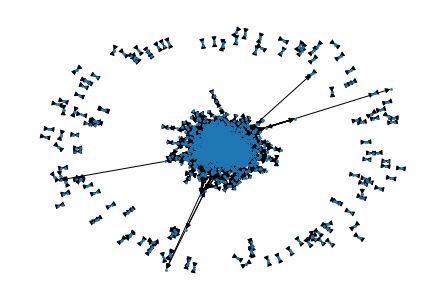

In [120]:
nx.draw(T,node_size=3)

In [117]:
#functions for calculating the impact influenced by https://link.springer.com/content/pdf/10.1007/s11192-021-04063-1.pdf

def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union

## p2 cited p1, and p1 influenced p2
def paper_citation_relation(G,p1,p2,f1,f2,c1,c2):
    if G.has_edge(p1,p2) and (c1+c2)!=0:
       return (c1/(c1+c2))+jaccard_similarity(f1, f2)
    else: return 0
#f1 is the list of keywords of paper p1
def keyword_citation_relation_raw(fi,fj,f1,f2):
    # if order is important
    #return 1/((f1.index(fi)+1)*(1+f2.index(fj)))
    #if not
    return 1
def keyword_citation_relation_pre(G,p1,p2,f1,f2,c1,c2,fi,fj):
    W_pp=paper_citation_relation(G,p1,p2,f1,f2,c1,c2)
    W_CA_Raw=keyword_citation_relation_raw(fi,fj,f1,f2)
    sum=0
    for i in f1:
        for j in f2:
            sum=sum+keyword_citation_relation_raw(i,j,f1,f2)
    return W_pp* W_CA_Raw/sum

def keyword_citation_relation(G,fi,fj):
    influence=0
    for node in G.nodes:
        if fi in nx.get_node_attributes(G,"keywords")[node]:
            c1=nx.get_node_attributes(G,"citation")[node]
            f1=nx.get_node_attributes(G,"keywords")[node]
            for neighbor in G.neighbors(node):
                if fj in nx.get_node_attributes(G,"keywords")[neighbor]:
                    c2=nx.get_node_attributes(G,"citation")[neighbor]
                    f2=nx.get_node_attributes(G,"keywords")[neighbor]
                    influence=influence+keyword_citation_relation_pre(G,node,neighbor,f1,f2,c1,c2,fi,fj)
    return influence

In [119]:
#Test the result
print(keyword_citation_relation(T,"Computer vision","Machine learning"))
print(keyword_citation_relation(T,"Machine learning","Computer vision"))
print(keyword_citation_relation(T,"Machine learning","Reinforcement learning"))
print(keyword_citation_relation(T,"Reinforcement learning","Machine learning"))
print(keyword_citation_relation(T,"Reinforcement learning","Computer vision"))
print(keyword_citation_relation(T,"Computer vision","Reinforcement learning"))

5.639602579164473
5.786785299851107
0.6604775856572851
0.6121305250785727
0.11597232242682072
0.15077631547178433
